# What drives the price of a car?

![Kurt used car dealership](images/kurt.jpeg)

**OVERVIEW**

This notebook explores a large dataset of used cars. Your goal is to find out what features drive the price of a car and to recommend to a used car dealership what characteristics consumers truly value.

## CRISP-DM Framework

* Business Understanding
* Data Understanding
* Data Preparation
* Modeling
* Evaluation
* Deployment

## Business Understanding
* Define the main goal: Identify and explain the drivers of used car prices.

* Frame the task as predicting car prices from their attributes, and preparing actionable recommendations for a used car dealership.

## Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Load data
df = pd.read_csv('data/vehicles.csv')
print(f"Shape: {df.shape}")
# Show basic info
print(df.info())

# Show first few rows
print(df.head())

# Show basic statistics for numeric columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Show unique values for some object columns (to get a sense of categorical fields)
for col in ['region', 'manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

Shape: (426880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-nul

## 2. Data Cleaning & Preprocessing

In [2]:
# Remove extreme price outliers
df = df[(df['price'] >= 1) & (df['price'] <= 200_000)]

# Remove entries missing critical data
df = df.dropna(subset=['year', 'manufacturer', 'model'])

# Filter to reasonable years
df = df[(df['year'] >= 1990) & (df['year'] <= 2025)]

# Filter unreasonable odometer readings
df = df[(df['odometer'] > 0) & (df['odometer'] <= 1_000_000)]

# Inspect missing values
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

# Inspect columns for potential removal
print('Columns:', df.columns.tolist())

# Example: manually exclude known non-informative features
drop_columns = [
    'id',               # unique identifier
    'VIN',              # unique vehicle identifier
    'title_status',     # condition has the salvage value, so this can be removed, add not much value
    'region',           # can be replaced by 'state' if you want location info
]

# Ensure columns to drop actually exist in the DataFrame
drop_columns = [col for col in drop_columns if col in df.columns]

# Drop columns with mostly missing values (>80% missing)
null_thresh = 0.8
mostly_missing = [col for col in df.columns if df[col].isnull().mean() > null_thresh]
drop_columns += mostly_missing

# Drop columns with only one unique value
one_unique = [col for col in df.columns if df[col].nunique() == 1]
drop_columns += one_unique

# Remove duplicates from drop_columns
drop_columns = list(set(drop_columns))

# Drop those columns
df_reduced = df.drop(columns=drop_columns)

print("Dropped columns:", drop_columns)
print("Remaining columns:", df_reduced.columns.tolist())

# Basic type conversions
df['year'] = df['year'].astype(int)

print(df_reduced.isnull().sum())

df_reduced = df_reduced.dropna()
# Show unique values for some object columns (to get a sense of categorical fields)
for col in ['manufacturer', 'condition', 'fuel','transmission', 'drive', 'size', 'type', 'paint_color', 'state']:
    if col in df_reduced.columns:
        print(f"\nUnique values in '{col}':")
        print(df_reduced[col].unique())
print(df_reduced.info())


size            0.723274
cylinders       0.407206
condition       0.386557
VIN             0.362809
drive           0.299092
paint_color     0.290500
type            0.204780
title_status    0.018813
fuel            0.005379
transmission    0.004022
dtype: float64
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']
Dropped columns: ['title_status', 'VIN', 'region', 'id']
Remaining columns: ['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
price                0
year                 0
manufacturer         0
model                0
condition       139561
cylinders       147016
fuel              1942
odometer             0
transmission      1452
drive           107983
size            261128
type             73933
paint_color     104881
stat

## 3. Exploratory Data Analysis (EDA)
### 3.1 Price Distribution

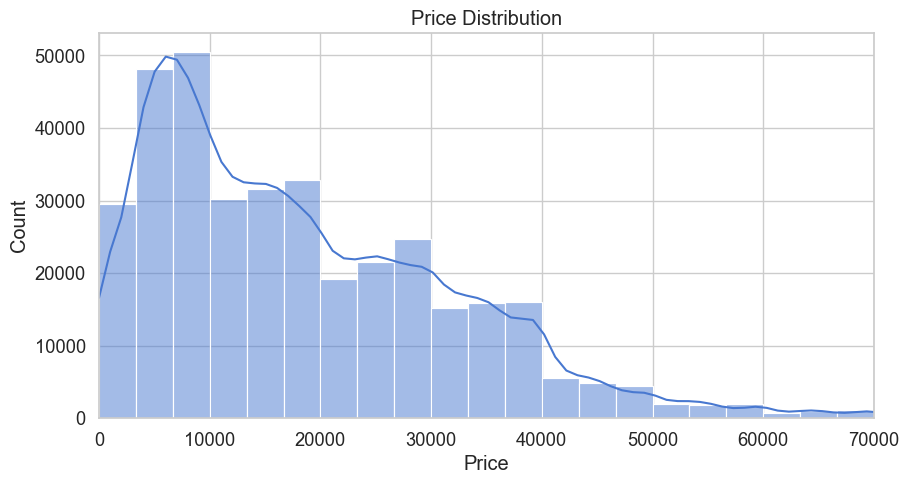

In [3]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=60, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.xlim(0, 70000)
plt.savefig('images/price_distribution.png')
plt.show()

### 3.2 Relationship with Quantitative Features

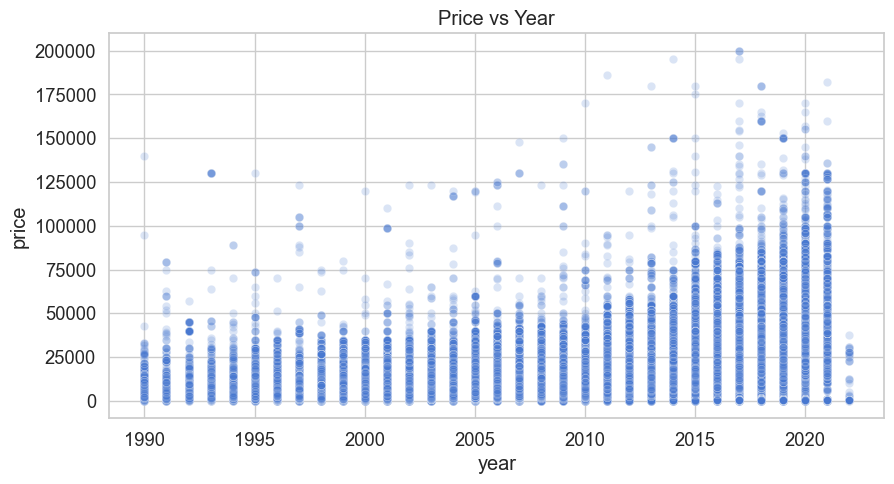

In [4]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='year', y='price', alpha=0.2)
plt.title('Price vs Year')
plt.savefig('images/price_year.png')
plt.show()

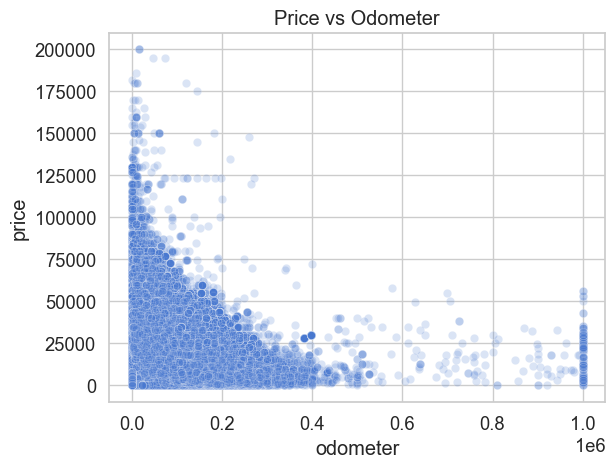

In [5]:
# Odometer (mileage) typically also matters
sns.scatterplot(data=df[df['odometer'].notnull()], x='odometer', y='price', alpha=0.2)
plt.title('Price vs Odometer')
plt.savefig('images/price_odo.png')
plt.show()

### 3.3 Categorical Features

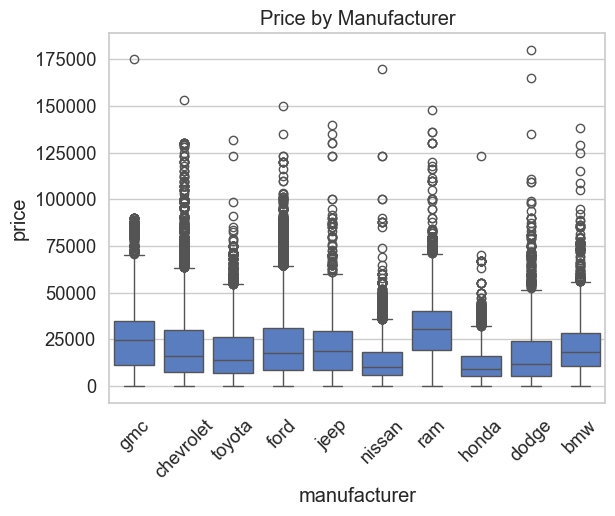

In [6]:
# Mean price by manufacturer
top_makes = df['manufacturer'].value_counts().head(10).index
sns.boxplot(data=df[df['manufacturer'].isin(top_makes)], x='manufacturer', y='price')
plt.xticks(rotation=45)
plt.title('Price by Manufacturer')
plt.savefig('images/price_manufacturer.png')
plt.show()

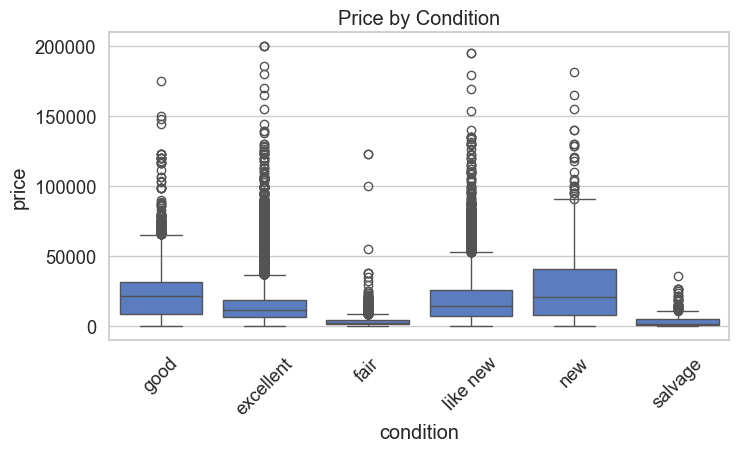

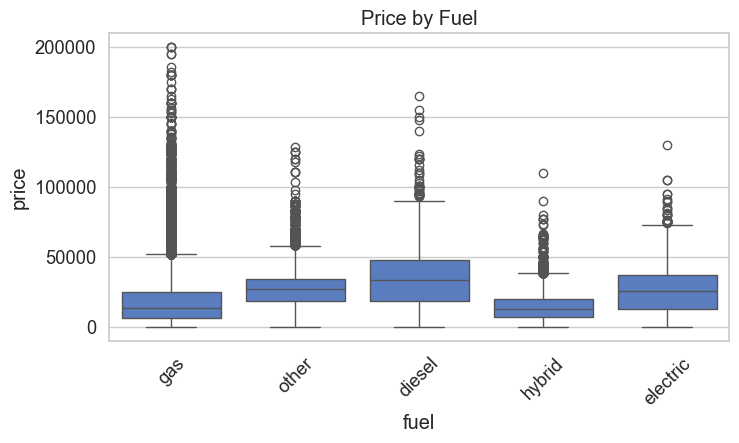

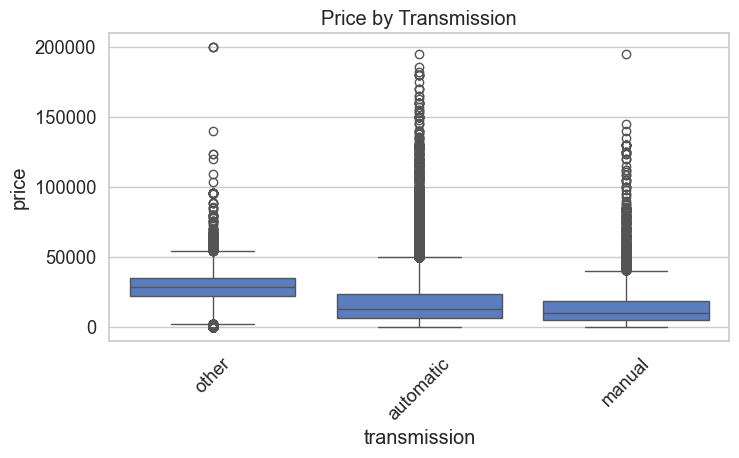

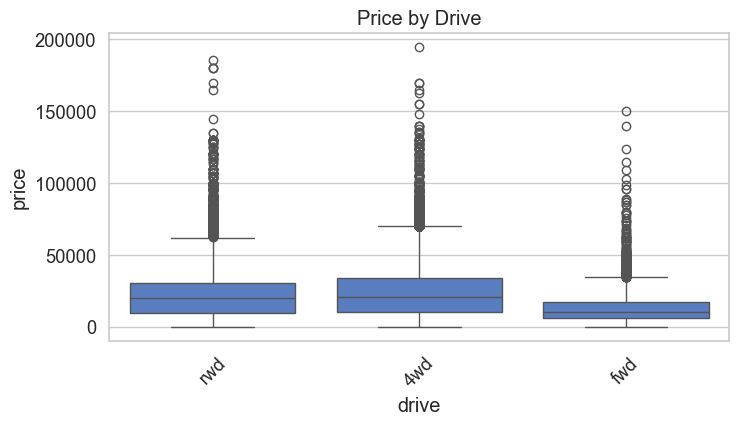

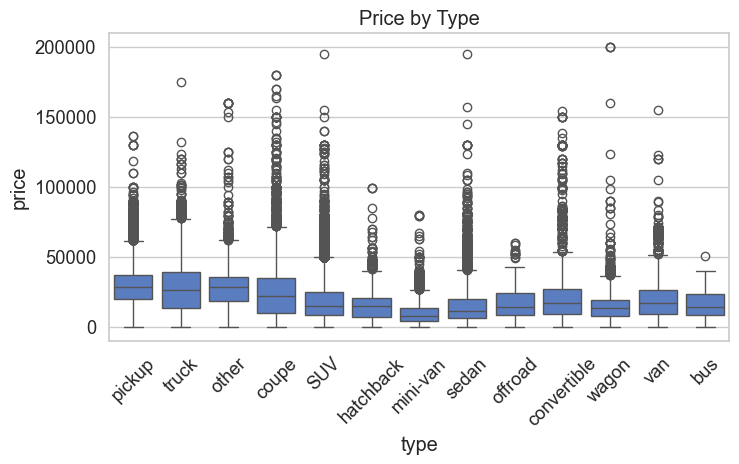

In [7]:
# Transmission, fuel, drive type
for col in ['condition', 'fuel', 'transmission', 'drive', 'type']:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x=col, y='price')
    plt.xticks(rotation=45)
    plt.title(f'Price by {col.capitalize()}')
    plt.savefig(f'images/price_{col}.png')
    plt.show()

## 4. Feature Engineering & Modeling
We'll build a regression model to estimate price using the most informative features.

In [12]:
X = df_reduced.drop("price", axis=1)
y = df_reduced["price"]
num_cols = ["year","odometer"] if "odometer" in df.columns else ["year"]
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- FEATURE ENGINEERING & ENCODING PIPELINE ---
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# --- RIDGE BASELINE with CV ---

ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RidgeCV(alphas=np.logspace(-2,2,20), cv=5))
])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("RidgeCV - Test: MAE", mean_absolute_error(y_test, y_pred_ridge),
      "| RMSE", mean_squared_error(y_test, y_pred_ridge)**0.5,
      "| R^2", r2_score(y_test, y_pred_ridge))

# Extract feature names after preprocessing
feature_names = ridge.named_steps["preprocessor"].get_feature_names_out()

# Extract coefficients from the trained Ridge regressor
coefficients = ridge.named_steps["regressor"].coef_

# Build DataFrame and rank by absolute magnitude
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
})

#for name, coef in zip(feature_names, coefficients):
#    print(f"{name}: {coef}")

print ("****************************************")
#print(feature_names)
#print(coefficients)

# Show top 10 most relevant features
print(importance_df.sort_values(by='abs_coef', ascending=False).head(30))

# --- 2. SEQUENTIAL FEATURE SELECTION (SFS) ---
# Use Linear Regression with SFS on encoded data
featurized_X_train = preprocessor.fit_transform(X_train)
featurized_X_test = preprocessor.transform(X_test)
lr = LinearRegression()

# SFS - can set direction: 'forward', 'backward', or 'bidirectional'
sfs = SequentialFeatureSelector(
    lr,
    n_features_to_select=7, # or 'auto' or a different value
    direction="forward",
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
sfs.fit(featurized_X_train, y_train)
print("Selected subset feature indices:", np.where(sfs.get_support())[0])

# Evaluate with selected features
X_train_sfs = featurized_X_train[:, sfs.get_support()]
X_test_sfs = featurized_X_test[:, sfs.get_support()]
lr.fit(X_train_sfs, y_train)
y_pred_sfs = lr.predict(X_test_sfs)
# Get processed feature names
feature_names = preprocessor.get_feature_names_out()

# Boolean mask of selected features
selected_mask = sfs.get_support()
selected_feature_names = feature_names[selected_mask]
print(selected_feature_names)

sfs_coefficients = lr.coef_

# Print selected features and their coefficients
for name, coef in zip(selected_feature_names, sfs_coefficients):
    print(f"{name}: {coef}")

print("SFS (7 features) - Test: MAE", mean_absolute_error(y_test, y_pred_sfs),
      "| RMSE", mean_squared_error(y_test, y_pred_sfs),
     "| R^2", r2_score(y_test, y_pred_sfs))

RidgeCV - Test: MAE 4345.646328066484 | RMSE 7160.877519116757 | R^2 0.6967506456353463
****************************************
                                    feature   coefficient      abs_coef
11                cat__manufacturer_ferrari  43024.750081  43024.750081
1336              cat__model_panamera turbo  34274.307787  34274.307787
1200                       cat__model_m805i  30945.918282  30945.918282
540              cat__model_corvette c8 z51  30827.459595  30827.459595
879     cat__model_f350 diesels powerstroke  29114.825300  29114.825300
541         cat__model_corvette convertible  25685.674886  25685.674886
891                         cat__model_f430  25367.012472  25367.012472
1334     cat__model_pacifica touring l plus  25286.884297  25286.884297
1491                         cat__model_rs3  24301.518553  24301.518553
880                     cat__model_f350 drw  23292.667019  23292.667019
1460                    cat__model_renegade  21700.476568  21700.476568
543    

## 6. Intepretation of results
# Key Findings: Model Performance and Feature Importance

## Ridge Regression — Key Findings

**Performance:**
- **MAE:** 4,345.65  
- **RMSE:** 7,160.88  
- **R²:** 0.697  
The model explains nearly 70% of the variance in car prices with a mean error of \$4,346 and a root mean squared error of \$7,161.

**Most Influential Features (by absolute coefficient):**
- `cat__manufacturer_ferrari`: 43,025  
- `cat__model_panamera turbo`: 34,274  
- `cat__model_m805i`: 30,946  
- `cat__model_corvette c8 z51`: 30,827  
- `cat__model_f350 diesels powerstroke`: 29,115  

**Interpretation:**  
- **Magnitude:** Larger coefficients have more impact.
- **Positive sign:** Indicates presence of the feature raises the car price.
- **Category encoding:** One-hot encoding means the coefficient reflects the average price lift vs. the reference group.

> **Takeaway:**  
Rare, luxury, or performance models (Ferrari, Panamera Turbo, etc.) have a huge positive effect on price, reflecting their market value.

---

## Sequential Feature Selection (SFS) — Key Findings

**Performance:**
- **MAE:** 5,485.82  
- **RMSE:** 73,257,889.82 *(check RMSE calculation/units)*  
- **R²:** 0.567  
The simpler SFS model with only 7 features performs less well, with larger errors and about 57% of variance explained.

**Selected Features & Coefficients:**  

| Feature Name               | Coefficient   | Effect                                  |
|---------------------------|--------------:|-----------------------------------------|
| num__year                 | 6,119.39      | Each newer year increases price         |
| num__odometer             | -3,077.32     | Each unit higher odometer lowers price  |
| cat__model_panamera turbo | 71,274.61     | Panamera Turbo model adds \$71,275      |
| cat__cylinders_4 cylinders| -4,418.47     | 4-cylinder engine lowers price          |
| cat__fuel_diesel          | 11,789.96     | Diesel cars raise price                 |
| cat__drive_fwd            | -6,438.28     | FWD reduces price                       |
| cat__type_truck           | 4,916.43      | Trucks are more valuable                |

**Interpretation:**  
- **Positive coefficients:** Increase price.
- **Negative coefficients:** Decrease price.

> **Takeaway:**  
SFS identifies both numeric and categorical factors. The year and presence of premium models (like “panamera turbo”) are critical price drivers. Mileage, engine, fuel, and drivetrain type have logical, interpretable effects.

---

**Summary:**  
*Ridge regression, leveraging the full set of features, better explains car price variation—especially due to rare luxury brands and specific performance models. SFS produces a more compact, highly interpretable feature set, confirming the key role of model, year, mileage, engine, and driveline characteristics in price determination.*

## 6. Conclusions & Recommendations

**Key findings:**

 The most relevant drivers for predicting car prices in your Ridge model are mainly individual luxury or performance models and rare manufacturers. Their large, positive coefficients show their strong association with higher car prices when all other features are held constant

 model_panamera turbo stands out as the single most influential feature, adding a large premium.

Numerical features (year, odometer) continue to have strong, logical impacts: newer cars fetch higher prices, more miles reduces value.

Other categorical features (diesel fuel, cylinder count, drive type, and body type truck) also contribute meaningfully, consistent with general automotive market trends.

**Recommendations to the dealership:**
 * Focus on sourcing vehicles with low mileage and newer model years.
 * Price premium for "excellent" condition listings is supported by data.
 * Consider upselling value-added features such as 4wd or premium transmission types.
